In [1]:
import warnings
warnings.filterwarnings('ignore')

import configparser
cfg = configparser.ConfigParser()
cfg.optionxform = str
cfg.read('/home/sarth/rootdir/datadir/assets/defaults.ini')
cfg = {s: dict(cfg.items(s)) for s in cfg.sections()}
PATHS = cfg['PATHS']

import torch
from torch import nn
import numpy as np
import pandas as pd
import xarray as xr
import networkx as nx
import matplotlib.pyplot as plt
import random
import os
import tqdm
import glob
import itertools
import pickle
import gc
import json
from torch.utils.data import Dataset, DataLoader

RUN_NAME = 'Run03'
PROJECT_DIR = os.path.join('/home/sarth/rootdir/workdir/projects/lumped_analysis_Jun2025')
ANALYSIS_DIR = os.path.join(PROJECT_DIR, 'analysis', RUN_NAME)
RESULTS_DIR = os.path.join(PROJECT_DIR, 'Results', RUN_NAME)

In [2]:
#%% Region-Specific: CAMELS-US
DIRNAME = '03min_GloFAS_CAMELS-US'
SAVE_PATH = os.path.join(PATHS['devp_datasets'], DIRNAME)
resolution = 0.05
lon_360_180 = lambda x: (x + 180) % 360 - 180 # convert 0-360 to -180-180
lon_180_360 = lambda x: x % 360 # convert -180-180 to 0-360
region_bounds = {
    'minx': -130,
    'miny': 20,
    'maxx': -65,
    'maxy': 50
}
camels_attributes_graph = pd.read_csv(os.path.join(SAVE_PATH, 'graph_attributes.csv'), index_col=0)
camels_attributes_graph.index = camels_attributes_graph.index.map(lambda x: str(x).zfill(8))
camels_attributes_graph['huc_02'] = camels_attributes_graph['huc_02'].map(lambda x: str(x).zfill(2))
camels_graph = camels_attributes_graph.copy()
camels_graph = camels_graph[camels_graph['area_percent_difference'] < 10]
camels_graph = camels_graph[camels_graph['num_nodes'] > 1]
print(f"Number of CAMELS-US catmt's: {len(camels_graph)}")
del camels_attributes_graph

Number of CAMELS-US catmt's: 395


In [ ]:
from scipy import stats, signal

def _mask_valid(pred, true):
    mask = ~np.isnan(true) & ~np.isnan(pred)
    pred = pred[mask]
    true = true[mask]
    pred[pred < 0] = 0
    true[true < 0] = 0
    return pred, true

def RMSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sqrt(np.mean((true - pred)**2))

def pearsonr(pred, true):
    pred, true = _mask_valid(pred, true)
    r, _ = stats.pearsonr(true, pred)
    return r

def NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return 1 - np.sum((true - pred)**2) / np.sum((true - np.mean(true))**2)

def KGE(pred, true):
    pred, true = _mask_valid(pred, true)
    r = pearsonr(pred, true)
    alpha = np.std(pred) / np.std(true)
    beta = np.mean(pred) / np.mean(true)
    return 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)

def PBIAS(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.sum(true - pred) / np.sum(true) * 100

def alpha_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return np.std(pred) / np.std(true)

def beta_NSE(pred, true):
    pred, true = _mask_valid(pred, true)
    return (np.mean(pred) - np.mean(true)) / np.std(true)

def _get_fdc(data):
    data = np.sort(data)[::-1]
    return data

def fdc_fms(pred, true, lower = 0.2, upper = 0.7):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    qsm_lower = np.log(sim[np.round(lower * len(sim)).astype(int)])
    qsm_upper = np.log(sim[np.round(upper * len(sim)).astype(int)])
    qom_lower = np.log(obs[np.round(lower * len(obs)).astype(int)])
    qom_upper = np.log(obs[np.round(upper * len(obs)).astype(int)])

    fms = ((qsm_lower - qsm_upper) - (qom_lower - qom_upper)) / (qom_lower - qom_upper + 1e-6)

    return fms * 100

def fdc_fhv(pred, true, h = 0.02):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)

    obs = obs[:np.round(h * len(obs)).astype(int)]
    sim = sim[:np.round(h * len(sim)).astype(int)]

    fhv = np.sum(sim - obs) / np.sum(obs)

    return fhv * 100

def fdc_flv(pred, true, l = 0.3):
    pred, true = _mask_valid(pred, true)

    sim = _get_fdc(pred)
    obs = _get_fdc(true)
    sim[sim <= 0] = 1e-6
    obs[obs <= 0] = 1e-6

    obs = obs[-np.round(l * len(obs)).astype(int):]
    sim = sim[-np.round(l * len(sim)).astype(int):]

    # transform values to log scale
    obs = np.log(obs)
    sim = np.log(sim)

    # calculate flv part by part
    qsl = np.sum(sim - sim.min())
    qol = np.sum(obs - obs.min())

    flv = -1 * (qsl - qol) / (qol + 1e-6)

    return flv * 100

def mean_peak_timing(pred, true, window = 3):
    pred, true = _mask_valid(pred, true)

    peaks, _ = signal.find_peaks(true, distance=2*window, prominence=np.std(true))

    # pred_idx_lst = []
    timing_error_lst = []
    for idx in peaks:
        if (pred[idx] > pred[idx - 1]) and (pred[idx] > pred[idx + 1]):
            peak_pred = pred[idx]
            peak_pred_idx = idx
        else:
            peak_pred_idx = np.argmax(pred[max(idx - window,0):idx + window + 1]) + max(idx - window,0)
            peak_pred = pred[peak_pred_idx]
        # pred_idx_lst.append(peak_pred_idx)
    
        peak_true = true[idx]
        timing_error = np.abs(peak_pred_idx - idx) 
        timing_error_lst.append(timing_error)
    
    mean_timing_error = np.mean(timing_error_lst) if len(timing_error_lst) > 0 else np.nan

    return mean_timing_error

def missed_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    missed_events = 0
    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) == 0:
            missed_events += 1
            # print(idx)
    
    missed_peak_values = (missed_events / len(peaks_obs_times)) * 100 if len(peaks_obs_times) > 0 else np.nan

    return missed_peak_values

def F1_score_of_capturing_peaks(pred, true, window = 3, threshold = 80):
    pred, true = _mask_valid(pred, true)

    peaks_obs_times, _ = signal.find_peaks(true, distance=2*window, height = np.percentile(true, threshold))
    peaks_sim_times, _ = signal.find_peaks(pred, distance=2*window, height = np.percentile(pred, threshold))
    
    true_positive_peaks = 0 # peak in obs and nearby in sim
    true_negative_peaks = 0 # no peak in obs and sim
    false_positive_peaks = 0 # peak in sim but not nearby in obs
    false_negative_peaks = 0 # peak in obs but not nearby in sim

    for idx in peaks_obs_times:
        nearby_peak_sim_index = np.where(np.abs(peaks_sim_times - idx) <= window)[0]
        if len(nearby_peak_sim_index) > 0:
            true_positive_peaks += 1
        else:
            false_negative_peaks += 1
    
    for idx in peaks_sim_times:
        nearby_peak_obs_index = np.where(np.abs(peaks_obs_times - idx) <= window)[0]
        if len(nearby_peak_obs_index) == 0:
            false_positive_peaks += 1

    precision = true_positive_peaks / (true_positive_peaks + false_positive_peaks) if (true_positive_peaks + false_positive_peaks) > 0 else np.nan
    recall = true_positive_peaks / (true_positive_peaks + false_negative_peaks) if (true_positive_peaks + false_negative_peaks) > 0 else np.nan
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else np.nan

    return f1_score

In [4]:
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

REGIONMASKS = {huc: torch.load(f"{PROJECT_DIR}/lumped_training_samples/regionmask/CAMELS-US/HUC{huc}.pt").numpy() for huc in HUCs}

for huc, mask in REGIONMASKS.items():
    print(f"HUC{huc}: {mask.sum()} ({mask.shape[0]})")

HUC01: 12 (395)
HUC02: 39 (395)
HUC03: 45 (395)
HUC04: 16 (395)
HUC05: 26 (395)
HUC06: 10 (395)
HUC07: 26 (395)
HUC08: 10 (395)
HUC09: 5 (395)
HUC10: 52 (395)
HUC11: 26 (395)
HUC12: 28 (395)
HUC13: 4 (395)
HUC14: 5 (395)
HUC15: 12 (395)
HUC16: 6 (395)
HUC17: 52 (395)
HUC18: 21 (395)


In [5]:
from matplotlib import category
import numpy as np
import os
import xarray as xr

import matplotlib.pyplot as plt

In [6]:
param_V = 3
param_L = 1
param_C = 1
suffix = 'pred_glofas' # 'pred_gauge' or 'glofas_gauge' or 'pred_glofas'
varname = 'NSE'
lead_time = 1
min_max = None
HUCs = [str(i).zfill(2) for i in range(1, 18+1)]

In [7]:
# all_upa --> np.log(camels_graph['area_geospa_fabric'])
all_upa = []
all_upa_orig = []
all_noflows = []
all_noflows_threshold = []

all_orig = []
all_clipped = []
colors = []

category_positive = 0
category_negative = 0
category_extreme_negative = 0

huc_boundaries = {}
current_index = 0
huc_centers = {}

y_sim = np.load(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'y_ground_truth.npy'))[:, lead_time - 1, :] # (num_samples, num_catmts)

for huc in itertools.islice(HUCs, 0, None, 1):
    camels_huc = camels_graph.loc[REGIONMASKS[huc].astype(bool)]
    upa_ori = camels_huc['area_geospa_fabric']
    all_upa_orig.extend(upa_ori.tolist())
    upa = np.log(camels_huc['area_geospa_fabric'])
    all_upa.extend(upa.tolist())

    y_sim_huc = y_sim[:, REGIONMASKS[huc].astype(bool)]
    # no-flow is fraction of time steps with zero flow
    noflows = np.sum(y_sim_huc == 0, axis=0) / y_sim_huc.shape[0]
    noflows_threshold = np.sum(y_sim_huc < 1.0, axis=0) / y_sim_huc.shape[0] # threshold of 1.0 cms
    all_noflows.extend(noflows.tolist())
    all_noflows_threshold.extend(noflows_threshold.tolist())

    ds = xr.open_dataset(os.path.join(ANALYSIS_DIR, 'evaluations', f"V{param_V}_L{param_L}_C{param_C}", f'metrics_{suffix}.nc'))
    huc_mask = REGIONMASKS[huc]
    huc_mask = np.where(huc_mask)[0]
    # Decrease each index by one
    huc_mask = huc_mask + 1
    # Use huc_mask to filter the dataset on dimension 'catmt_idx'
    ds = ds.sel(catmt_idx=huc_mask)
    # Get the metric values for the chosen lead time and variable; flatten them to 1D array
    arr = ds.sel(lead_time=lead_time)[varname].values.flatten()
    n = len(arr)
    # Record the start and end indices for this HUC group
    huc_boundaries[huc] = (current_index, current_index + n)

    for val in arr:
        all_orig.append(val)
        if val < -10:
            clipped = -1
            colors.append('red')
            category_extreme_negative += 1
        else:
            clipped = np.clip(val, -1, 1)
            if clipped < 0:
                colors.append('orange')
                category_negative += 1
            else:
                colors.append('blue')
                category_positive += 1
        all_clipped.append(float(clipped))
    
    current_index += n

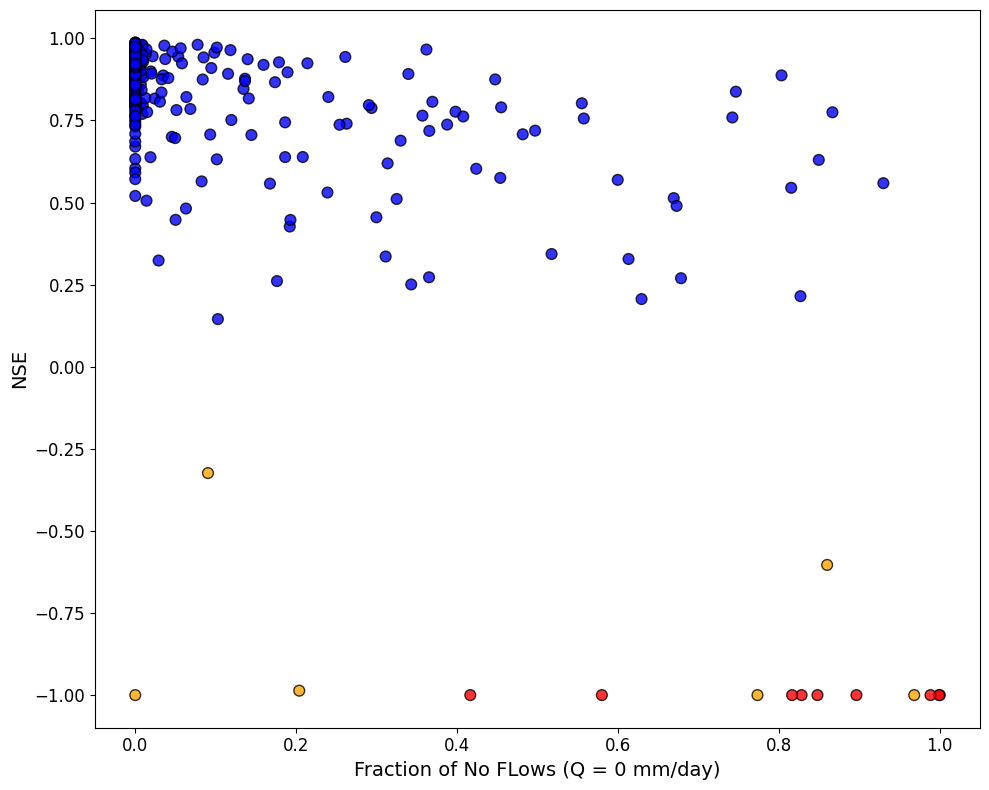

In [9]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
# plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q = 0 mm/day)", fontsize=14)
plt.ylabel(varname, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

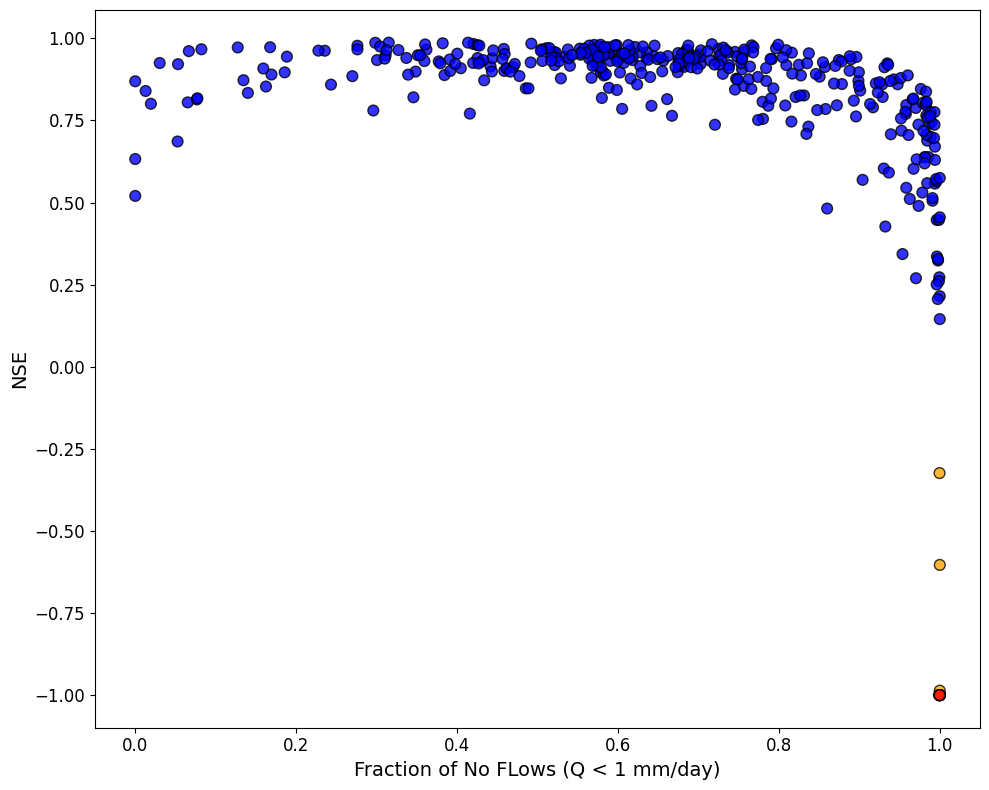

In [10]:
plt.figure(figsize=(10, 8))
# Scatter plot for no flows using circle markers.
# plt.scatter(all_noflows, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows')
plt.scatter(all_noflows_threshold, all_clipped, c=colors, edgecolors='k', s=60, alpha=0.8, marker='o', label='No Flows Threshold')

plt.xlabel("Fraction of No FLows (Q < 1 mm/day)", fontsize=14)
plt.ylabel(varname, fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
df = pd.DataFrame({
    'NSE': all_orig,
    'NSE_clipped': all_clipped,
    'No_Flows': all_noflows,
    'No_Flows_Threshold': all_noflows_threshold,
    'color': colors
})
df

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color
0,0.987114,0.987114,0.000000,0.315068,blue
1,0.785399,0.785399,0.000000,0.605205,blue
2,0.977675,0.977675,0.000000,0.276164,blue
3,0.788077,0.788077,0.293699,0.970137,blue
4,0.956013,0.956013,0.000000,0.687671,blue
...,...,...,...,...,...
390,0.973649,0.973649,0.000000,0.583562,blue
391,0.916181,0.916181,0.000000,0.568493,blue
392,0.814972,0.814972,0.000000,0.661096,blue
393,0.922175,0.922175,0.000000,0.397808,blue


In [49]:
# conditions = [df['NSE'] < -1, df['NSE'] < 0, df['NSE'] < 0.6]
# choices = [0.25, 0.5, 0.75]
# df['NSE_class'] = np.select(conditions, choices, default=1.0)

conditions = [df['No_Flows'] < 0.15, df['No_Flows'] < 0.5, df['No_Flows'] < 0.85]
choices = [0.25, 0.5, 0.75]
df['No_Flows_class'] = np.select(conditions, choices, default=1.0)

conditions = [df['No_Flows_Threshold'] < 0.15, df['No_Flows_Threshold'] < 0.5, df['No_Flows_Threshold'] < 0.85]
choices = [0.25, 0.5, 0.75]
df['No_Flows_Threshold_class'] = np.select(conditions, choices, default=1.0)

df

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class
0,0.987114,0.987114,0.000000,0.315068,blue,0.25,0.50
1,0.785399,0.785399,0.000000,0.605205,blue,0.25,0.75
2,0.977675,0.977675,0.000000,0.276164,blue,0.25,0.50
3,0.788077,0.788077,0.293699,0.970137,blue,0.50,1.00
4,0.956013,0.956013,0.000000,0.687671,blue,0.25,0.75
...,...,...,...,...,...,...,...
390,0.973649,0.973649,0.000000,0.583562,blue,0.25,0.75
391,0.916181,0.916181,0.000000,0.568493,blue,0.25,0.75
392,0.814972,0.814972,0.000000,0.661096,blue,0.25,0.75
393,0.922175,0.922175,0.000000,0.397808,blue,0.25,0.50


In [98]:
data = df.copy()
data = data.sort_values(by=['No_Flows','No_Flows_Threshold','NSE'], ascending = [False, False, True]).reset_index(drop=True)
cond_red = data['NSE'] < -10
cond_orange = (data['NSE'] >= -10) & (data['NSE'] < -1)
cond_lightblue = (data['NSE'] >= -1) & (data['NSE'] < 0.3)
cond_blue = (data['NSE'] >= 0.3) & (data['NSE'] < 0.6)
cond_darkblue = (data['NSE'] >= 0.6) & (data['NSE'] < 1)

data['color'] = np.select(
    [cond_red, cond_orange, cond_lightblue, cond_blue, cond_darkblue],
    ['red', 'orange', 'lightblue', 'blue', 'darkblue'],
    default=data['color']
)
data

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class
0,-inf,-1.000000,1.000000,1.000000,red,1.00,1.00
1,-2054.722900,-1.000000,0.999178,1.000000,red,1.00,1.00
2,-67.874443,-1.000000,0.988493,1.000000,red,1.00,1.00
3,-3.935398,-1.000000,0.968219,1.000000,orange,1.00,1.00
4,0.559067,0.559067,0.929863,0.984384,blue,1.00,1.00
...,...,...,...,...,...,...,...
390,0.800876,0.800876,0.000000,0.019452,darkblue,0.25,0.25
391,0.839801,0.839801,0.000000,0.012877,darkblue,0.25,0.25
392,0.520213,0.520213,0.000000,0.000000,blue,0.25,0.25
393,0.632561,0.632561,0.000000,0.000000,darkblue,0.25,0.25


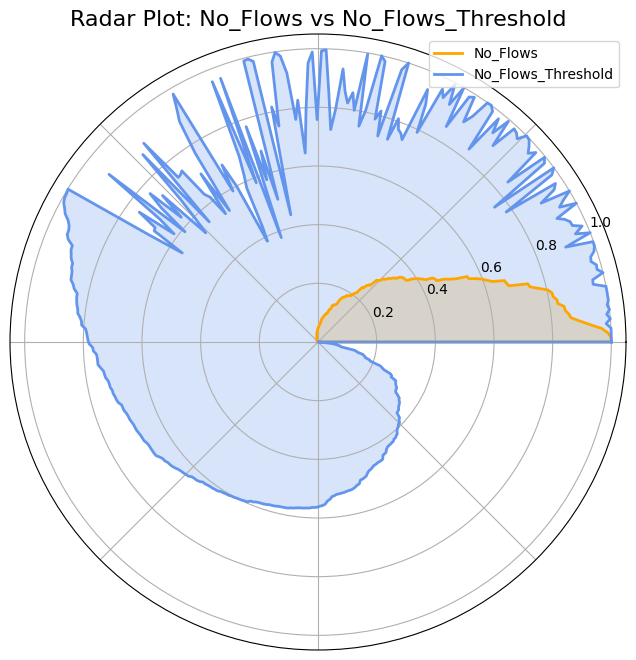

In [88]:
n_spokes = len(data)
angles = np.linspace(0, 2*np.pi, n_spokes, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # complete the loop

vals_nf = data['No_Flows'].values
vals_nft = data['No_Flows_Threshold'].values
vals_nf = np.concatenate((vals_nf, [vals_nf[0]]))
vals_nft = np.concatenate((vals_nft, [vals_nft[0]]))

plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)
ax.plot(angles, vals_nf, label='No_Flows', color='orange', linewidth=2)
ax.fill(angles, vals_nf, alpha=0.25, color='orange')
ax.plot(angles, vals_nft, label='No_Flows_Threshold', color='cornflowerblue', linewidth=2)
ax.fill(angles, vals_nft, alpha=0.25, color='cornflowerblue')
ax.set_title("Radar Plot: No_Flows vs No_Flows_Threshold", fontsize=16)
ax.set_xticklabels([])  # remove numerous x tick labels
ax.legend(loc='upper right')
plt.show()

In [96]:
data.tail(15)

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class
380,0.872674,0.872674,0.0,0.134521,blue,0.25,0.25
381,0.972390,0.972390,0.0,0.127397,blue,0.25,0.25
382,0.966848,0.966848,0.0,0.082192,blue,0.25,0.25
383,0.817708,0.817708,0.0,0.077260,blue,0.25,0.25
384,0.814165,0.814165,0.0,0.076438,blue,0.25,0.25
385,0.961226,0.961226,0.0,0.066575,blue,0.25,0.25
386,0.805103,0.805103,0.0,0.065205,blue,0.25,0.25
387,0.921470,0.921470,0.0,0.053151,blue,0.25,0.25
388,0.685976,0.685976,0.0,0.052603,blue,0.25,0.25
389,0.925014,0.925014,0.0,0.030411,blue,0.25,0.25


In [ ]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

n_spokes = len(data)
angles = np.linspace(0, 2*np.pi, n_spokes, endpoint=False)
angles = np.concatenate((angles, [angles[0]]))  # complete the loop

vals_nf = data['No_Flows_class'].values
vals_nft = data['No_Flows_Threshold_class'].values
vals_nf = np.concatenate((vals_nf, [vals_nf[0]]))
vals_nft = np.concatenate((vals_nft, [vals_nft[0]]))

plt.figure(figsize=(16, 16), dpi = 600)
ax = plt.subplot(111, polar=True)
ax.plot(angles, vals_nf, label='Q = 0 mm/day', color='orange', linewidth=2, alpha=0.7)
ax.fill(angles, vals_nf, alpha=0.33, color='orange')
ax.plot(angles, vals_nft, label='Q < 1 mm/day', color='cornflowerblue', linewidth=2, alpha=0.7)
ax.fill(angles, vals_nft, alpha=0.25, color='cornflowerblue')


#     ax.scatter(angles[i], vals_nf[i], color=data['color'].iloc[i], edgecolors='k', s=10, zorder=5)
#     ax.scatter(angles[i], vals_nft[i], color=data['color'].iloc[i], edgecolors='k', s=10, zorder=5)

colors_list = data['color'].tolist()
# Repeat the colors to match the length of angles (n_spokes + 1)
colors_list.append(colors_list[0])  # Append the first color to close the loop
ax.scatter(angles, vals_nf, c=colors_list, edgecolors='none', s=10, zorder=5, alpha=0.75)
ax.scatter(angles, vals_nft, c=colors_list, edgecolors='none', s=10, zorder=5, alpha=0.75)

# Add scatter markers using colors from column 'color'
for i in range(len(data)):
    if data['color'].iloc[i] in ['orange', 'red']:
        # Draw a circle around these points
        ax.scatter(angles[i], vals_nf[i], facecolors='none', edgecolors='k', s=20, zorder=6)
        ax.scatter(angles[i], vals_nft[i], facecolors='none', edgecolors='k', s=20, zorder=6)

# ax.set_title("Radar Plot: No_Flows vs No_Flows_Threshold", fontsize=16)
ax.set_xticklabels([])  # remove numerous x tick labels
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(["[0.00-0.15)", "[0.15-0.50)", "[0.50-0.85)", "[0.85-1.00]"], fontsize=8, fontweight='bold')
# lg = ax.legend(loc='lower right')

# Custom legend for flow conditions
flow_handles = [
    Patch(facecolor='orange', edgecolor='orange', label='Q = 0 mm/day'),
    Patch(facecolor='cornflowerblue', edgecolor='cornflowerblue', label='Q < 1 mm/day')
]
legend_flow = ax.legend(handles=flow_handles, loc='upper left', bbox_to_anchor=(0.8, 0.075), fontsize=10)
ax.add_artist(legend_flow)

# Custom legend for NSE ranges with points in order: darkblue, blue, lightblue, orange, red
nse_handles = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='darkblue', markersize=8, label=r'NSE $\in$ [0.6,1.0)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label=r'NSE $\in$ [0.3,0.6)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=8, label=r'NSE $\in$ [-1.0,0.3)'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label=r'NSE $\in$ [-10.0,-1.0)', markeredgecolor='k', markeredgewidth=1),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label=r'NSE < -10.0', markeredgecolor='k', markeredgewidth=1)
]
legend_nse = ax.legend(handles=nse_handles, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5, fontsize=10)

ax.annotate("", 
            xy=(0, 1.0), xytext=(0, 0.0),
            textcoords='data',
            arrowprops=dict(arrowstyle="->", color='black', lw=2),
            fontsize=10, ha='center', va='center', fontstyle='italic')
# Test separately: Fraction of No Flows\n(Binned)
ax.text(-0.20, 0.75, 'Fraction of No Flows\n(Binned)', transform=ax.get_xaxis_transform(), ha='center', va='bottom', fontsize=10, fontstyle='italic', fontweight='bold')

plt.show()

In [ ]:
# In what sorting order to keep the 395 catchments for the barplot?

In [140]:
data

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class
0,-inf,-1.000000,1.000000,1.000000,red,1.00,1.00
1,-2054.722900,-1.000000,0.999178,1.000000,red,1.00,1.00
2,-67.874443,-1.000000,0.988493,1.000000,red,1.00,1.00
3,-3.935398,-1.000000,0.968219,1.000000,orange,1.00,1.00
4,0.559067,0.559067,0.929863,0.984384,blue,1.00,1.00
...,...,...,...,...,...,...,...
390,0.800876,0.800876,0.000000,0.019452,darkblue,0.25,0.25
391,0.839801,0.839801,0.000000,0.012877,darkblue,0.25,0.25
392,0.520213,0.520213,0.000000,0.000000,blue,0.25,0.25
393,0.632561,0.632561,0.000000,0.000000,darkblue,0.25,0.25


In [159]:
data = df.copy()
data.head()

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class,color2
0,0.987114,0.987114,0.000000,0.315068,blue,0.25,0.50,darkblue
1,0.785399,0.785399,0.000000,0.605205,blue,0.25,0.75,darkblue
2,0.977675,0.977675,0.000000,0.276164,blue,0.25,0.50,darkblue
3,0.788077,0.788077,0.293699,0.970137,blue,0.50,1.00,darkblue
4,0.956013,0.956013,0.000000,0.687671,blue,0.25,0.75,darkblue


In [174]:
cond_red = df['NSE'] < -10
cond_orange = (df['NSE'] >= -10) & (df['NSE'] < 0.0)
cond_lightgreen = (df['NSE'] >= 0.0) & (df['NSE'] < 0.6)
cond_darkgreen = (df['NSE'] >= 0.6) & (df['NSE'] < 1)

df['color'] = np.select(
    [cond_red, cond_orange, cond_lightgreen, cond_darkgreen],
    ['red', 'orange', 'lightgreen', 'darkgreen'],
    default=df['color']
)

In [175]:
df

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class,color2
0,0.987114,0.987114,0.000000,0.315068,darkgreen,0.25,0.50,darkblue
1,0.785399,0.785399,0.000000,0.605205,darkgreen,0.25,0.75,darkblue
2,0.977675,0.977675,0.000000,0.276164,darkgreen,0.25,0.50,darkblue
3,0.788077,0.788077,0.293699,0.970137,darkgreen,0.50,1.00,darkblue
4,0.956013,0.956013,0.000000,0.687671,darkgreen,0.25,0.75,darkblue
...,...,...,...,...,...,...,...,...
390,0.973649,0.973649,0.000000,0.583562,darkgreen,0.25,0.75,darkblue
391,0.916181,0.916181,0.000000,0.568493,darkgreen,0.25,0.75,darkblue
392,0.814972,0.814972,0.000000,0.661096,darkgreen,0.25,0.75,darkblue
393,0.922175,0.922175,0.000000,0.397808,darkgreen,0.25,0.50,darkblue


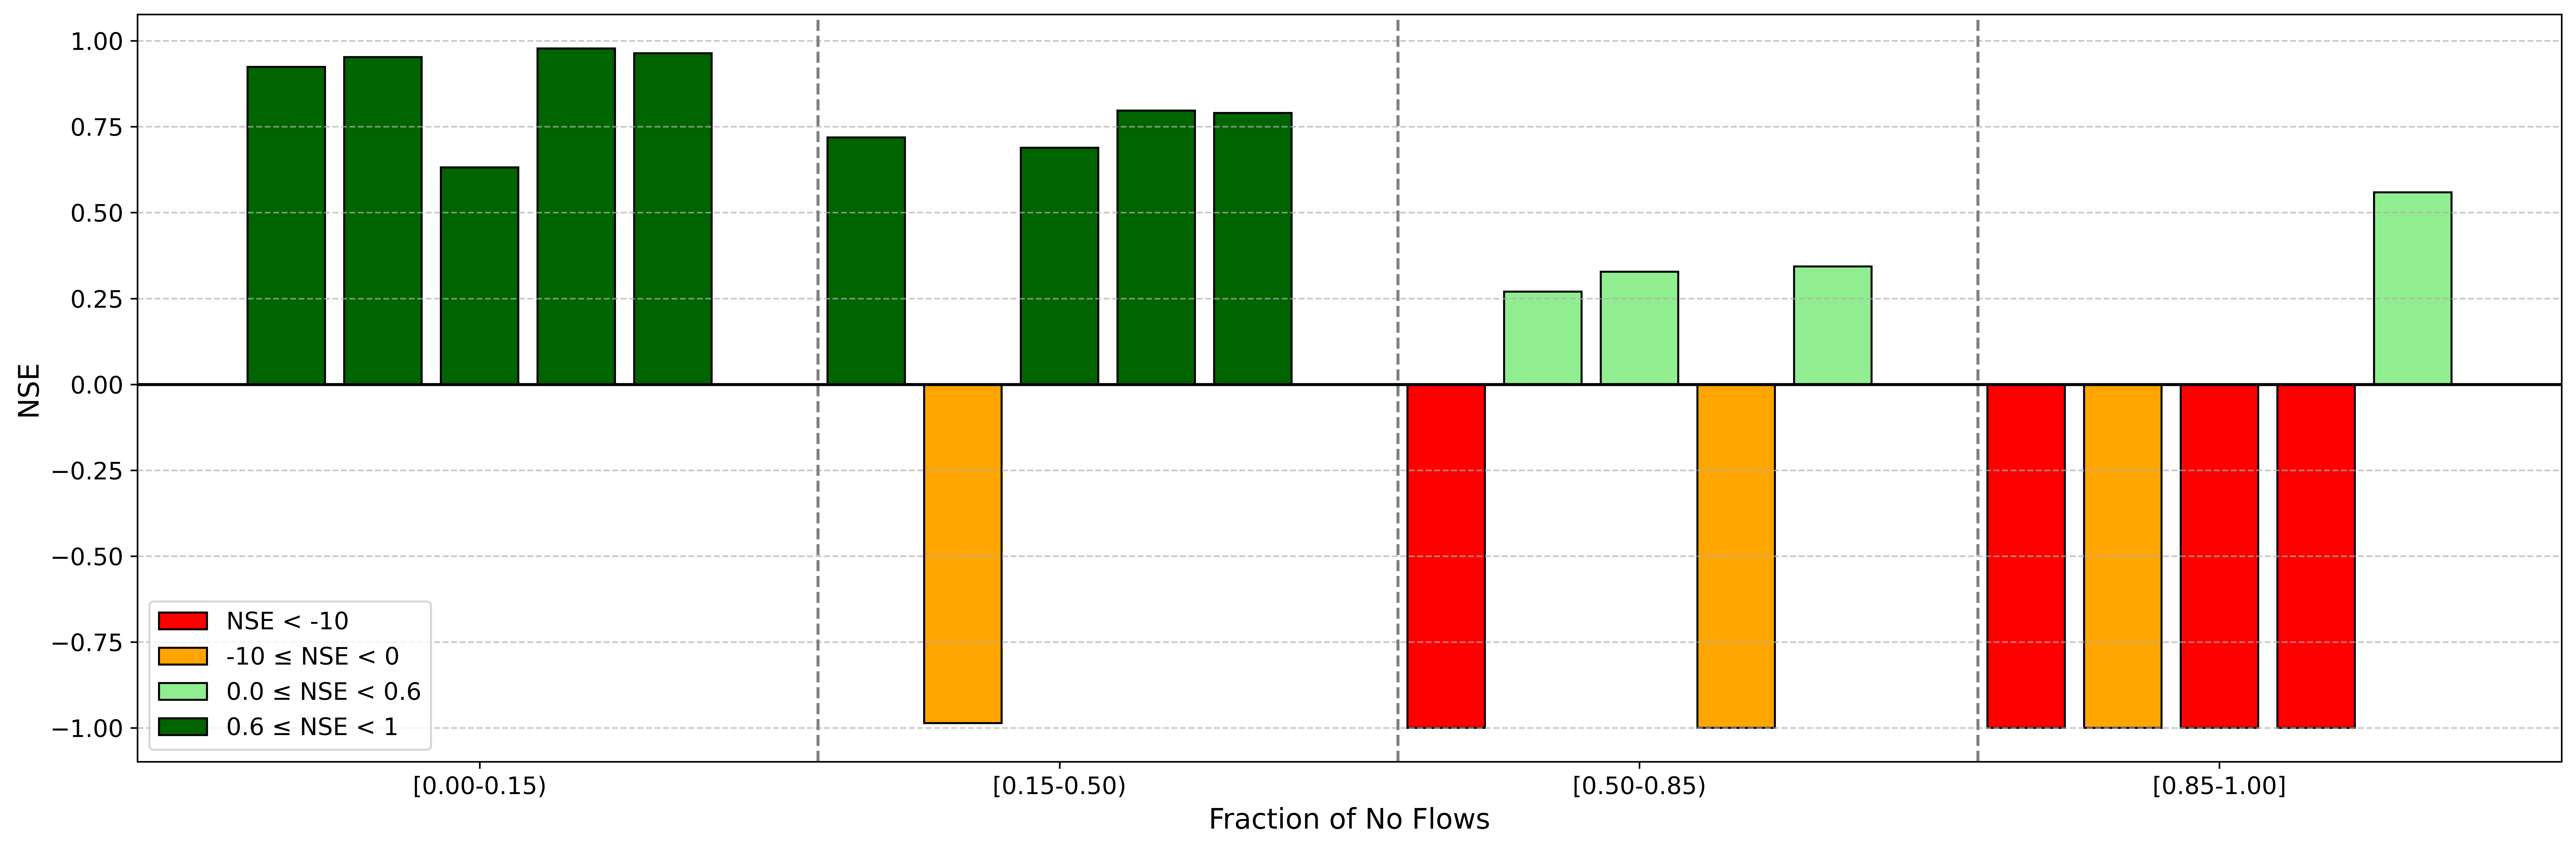

In [178]:
from matplotlib.patches import Patch

# Set default sample size and random seed for reproducibility
sample_size = 5
np.random.seed(111)

# Group the dataframe by the 'No_Flows_class' column which has unique bin values (0.25, 0.5, 0.75, 1.0)
groups = df.groupby('No_Flows_class')

# For each bin group, randomly sample 'sample_size' unique rows
sampled_list = [group.sample(n=sample_size, random_state=42) for key, group in groups]
samples_df = pd.concat(sampled_list).reset_index(drop=True)
# samples_df['NSE_clipped'] = abs(samples_df['NSE_clipped'])  # Use absolute values for bar heights

# Prepare x positions for the bar plot ensuring a gap ("kink") between each bin class group.
# We'll set a gap of 1 unit between groups.
bins_sorted = sorted(df['No_Flows_class'].unique())  # [0.25, 0.5, 0.75, 1.0]
x_positions = []      # x positions for each bar
group_centers = []    # center positions for xtick labels
gap = 1             # gap units between groups

for i, b in enumerate(bins_sorted):
    # Get the sample for current bin group
    group_data = samples_df[samples_df['No_Flows_class'] == b]

    # Determine x positions for current group.
    start_pos = i * (sample_size + gap)
    pos = list(range(start_pos, start_pos + len(group_data)))
    x_positions.extend(pos)
    # Compute center position for label
    group_centers.append(np.mean(pos))

# Plot the bar graph using 'NSE_clipped' as bar heights and column 'color' for bar colors.
plt.figure(figsize=(18, 6), dpi = 600)
plt.bar(x_positions, samples_df['NSE_clipped'], color=samples_df['color'], edgecolor='k')
plt.ylabel("NSE", fontsize=14)

# Set the x-tick labels at the center of each bin group
# x-ticks as [0.0-0.15), [0.15-0.50), [0.50-0.85), [0.85-1.00]
plt.xticks(group_centers, ['[0.00-0.15)', '[0.15-0.50)', '[0.50-0.85)', '[0.85-1.00]'], fontsize=12)
plt.xlabel("Fraction of No Flows", fontsize=14)

# Draw vertical dashed lines as 'kinks' to visually separate the groups.
for i in range(1, len(bins_sorted)):
    kink_pos = i * (sample_size + gap) - 0.5
    plt.axvline(x=kink_pos, color='gray', linestyle='--')



plt.yticks(fontsize=12)

legend_elements = [
    Patch(facecolor='red', edgecolor='k', label='NSE < -10'),
    Patch(facecolor='orange', edgecolor='k', label='-10 ≤ NSE < 0'),
    Patch(facecolor='lightgreen', edgecolor='k', label='0.0 ≤ NSE < 0.6'),
    Patch(facecolor='darkgreen', edgecolor='k', label=r'0.6 ≤ NSE < 1')
]
plt.legend(handles=legend_elements, fontsize=12, title_fontsize=14, loc='lower left')
plt.axhline(y=0, color='black', linestyle='-')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [143]:
group_data

,NSE,NSE_clipped,No_Flows,No_Flows_Threshold,color,No_Flows_class,No_Flows_Threshold_class
15,-inf,-1.000000,1.000000,1.000000,red,1.0,1.0
16,-3.935398,-1.000000,0.968219,1.000000,orange,1.0,1.0
17,-54.285816,-1.000000,0.896438,1.000000,red,1.0,1.0
18,-67.874443,-1.000000,0.988493,1.000000,red,1.0,1.0
19,0.559067,0.559067,0.929863,0.984384,blue,1.0,1.0
